# Libraries

In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2
import json
from glob import glob
import os
import tqdm
from collections import defaultdict
import pandas as pd
from utils import read_img

# Metadata

In [2]:
format = '.png'

In [3]:
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

In [4]:
colors_file = r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\src\metadata\rgb_colors.json"
porosty_file = r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\src\metadata\porosty_info.json"

colors = load_json(colors_file)
porosty = load_json(porosty_file)

In [5]:
colors_file = r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\src\metadata\rgb_colors.json"
porosty_file = r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\src\metadata\porosty_info.json"

colors = load_json(colors_file)
porosty = load_json(porosty_file)

In [6]:
colors

{'Black': [0, 0, 0],
 'Green': [0, 255, 0],
 'Violet': [255, 0, 255],
 'Yellow': [255, 255, 0],
 'Red': [255, 0, 0],
 'Turquoise': [0, 255, 255]}

In [7]:
porosty

[{'Year': '2024',
  'classes': [{'name': 'Порода', 'color': 'Black', 'index': 0},
   {'name': 'Внеформенная пористость', 'color': 'Green', 'index': 1},
   {'name': 'Внутриформенная пористость', 'color': 'Violet', 'index': 2},
   {'name': 'Микропористость', 'color': 'Yellow', 'index': 3},
   {'name': 'Трещины', 'color': 'Red', 'index': 4},
   {'name': 'Каверны', 'color': 'Turquoise', 'index': 5}]}]

In [8]:
indexed_colors = [{'color_value': np.array(colors[c['color']]),
                  'index': c['index']}
                    for c in porosty[0]['classes']]
indexed_colors

[{'color_value': array([0, 0, 0]), 'index': 0},
 {'color_value': array([  0, 255,   0]), 'index': 1},
 {'color_value': array([255,   0, 255]), 'index': 2},
 {'color_value': array([255, 255,   0]), 'index': 3},
 {'color_value': array([255,   0,   0]), 'index': 4},
 {'color_value': array([  0, 255, 255]), 'index': 5}]

In [9]:
NUM_CLASSES = len(porosty[0]['classes'])

# Processing functions

In [37]:
unique = {0, 255}

def convert2rgb(image):
    image = np.array(image)
    image = np.where(image < 128, 0, 255)
    condition = ~(image[:, :, 3] == 0)
    conds = np.stack([condition for _ in range(4)], axis=-1)
    image = np.where(conds, image, 0)
    return cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGBA2RGB)

In [38]:
def convert2mask(image):
    mask = np.zeros_like(image[:, :, 0])

    for elem in indexed_colors:
        condition = np.all(image == elem['color_value'], axis=-1)
        mask = np.where(condition, elem['index'], mask)
    return mask

# Pipeline example

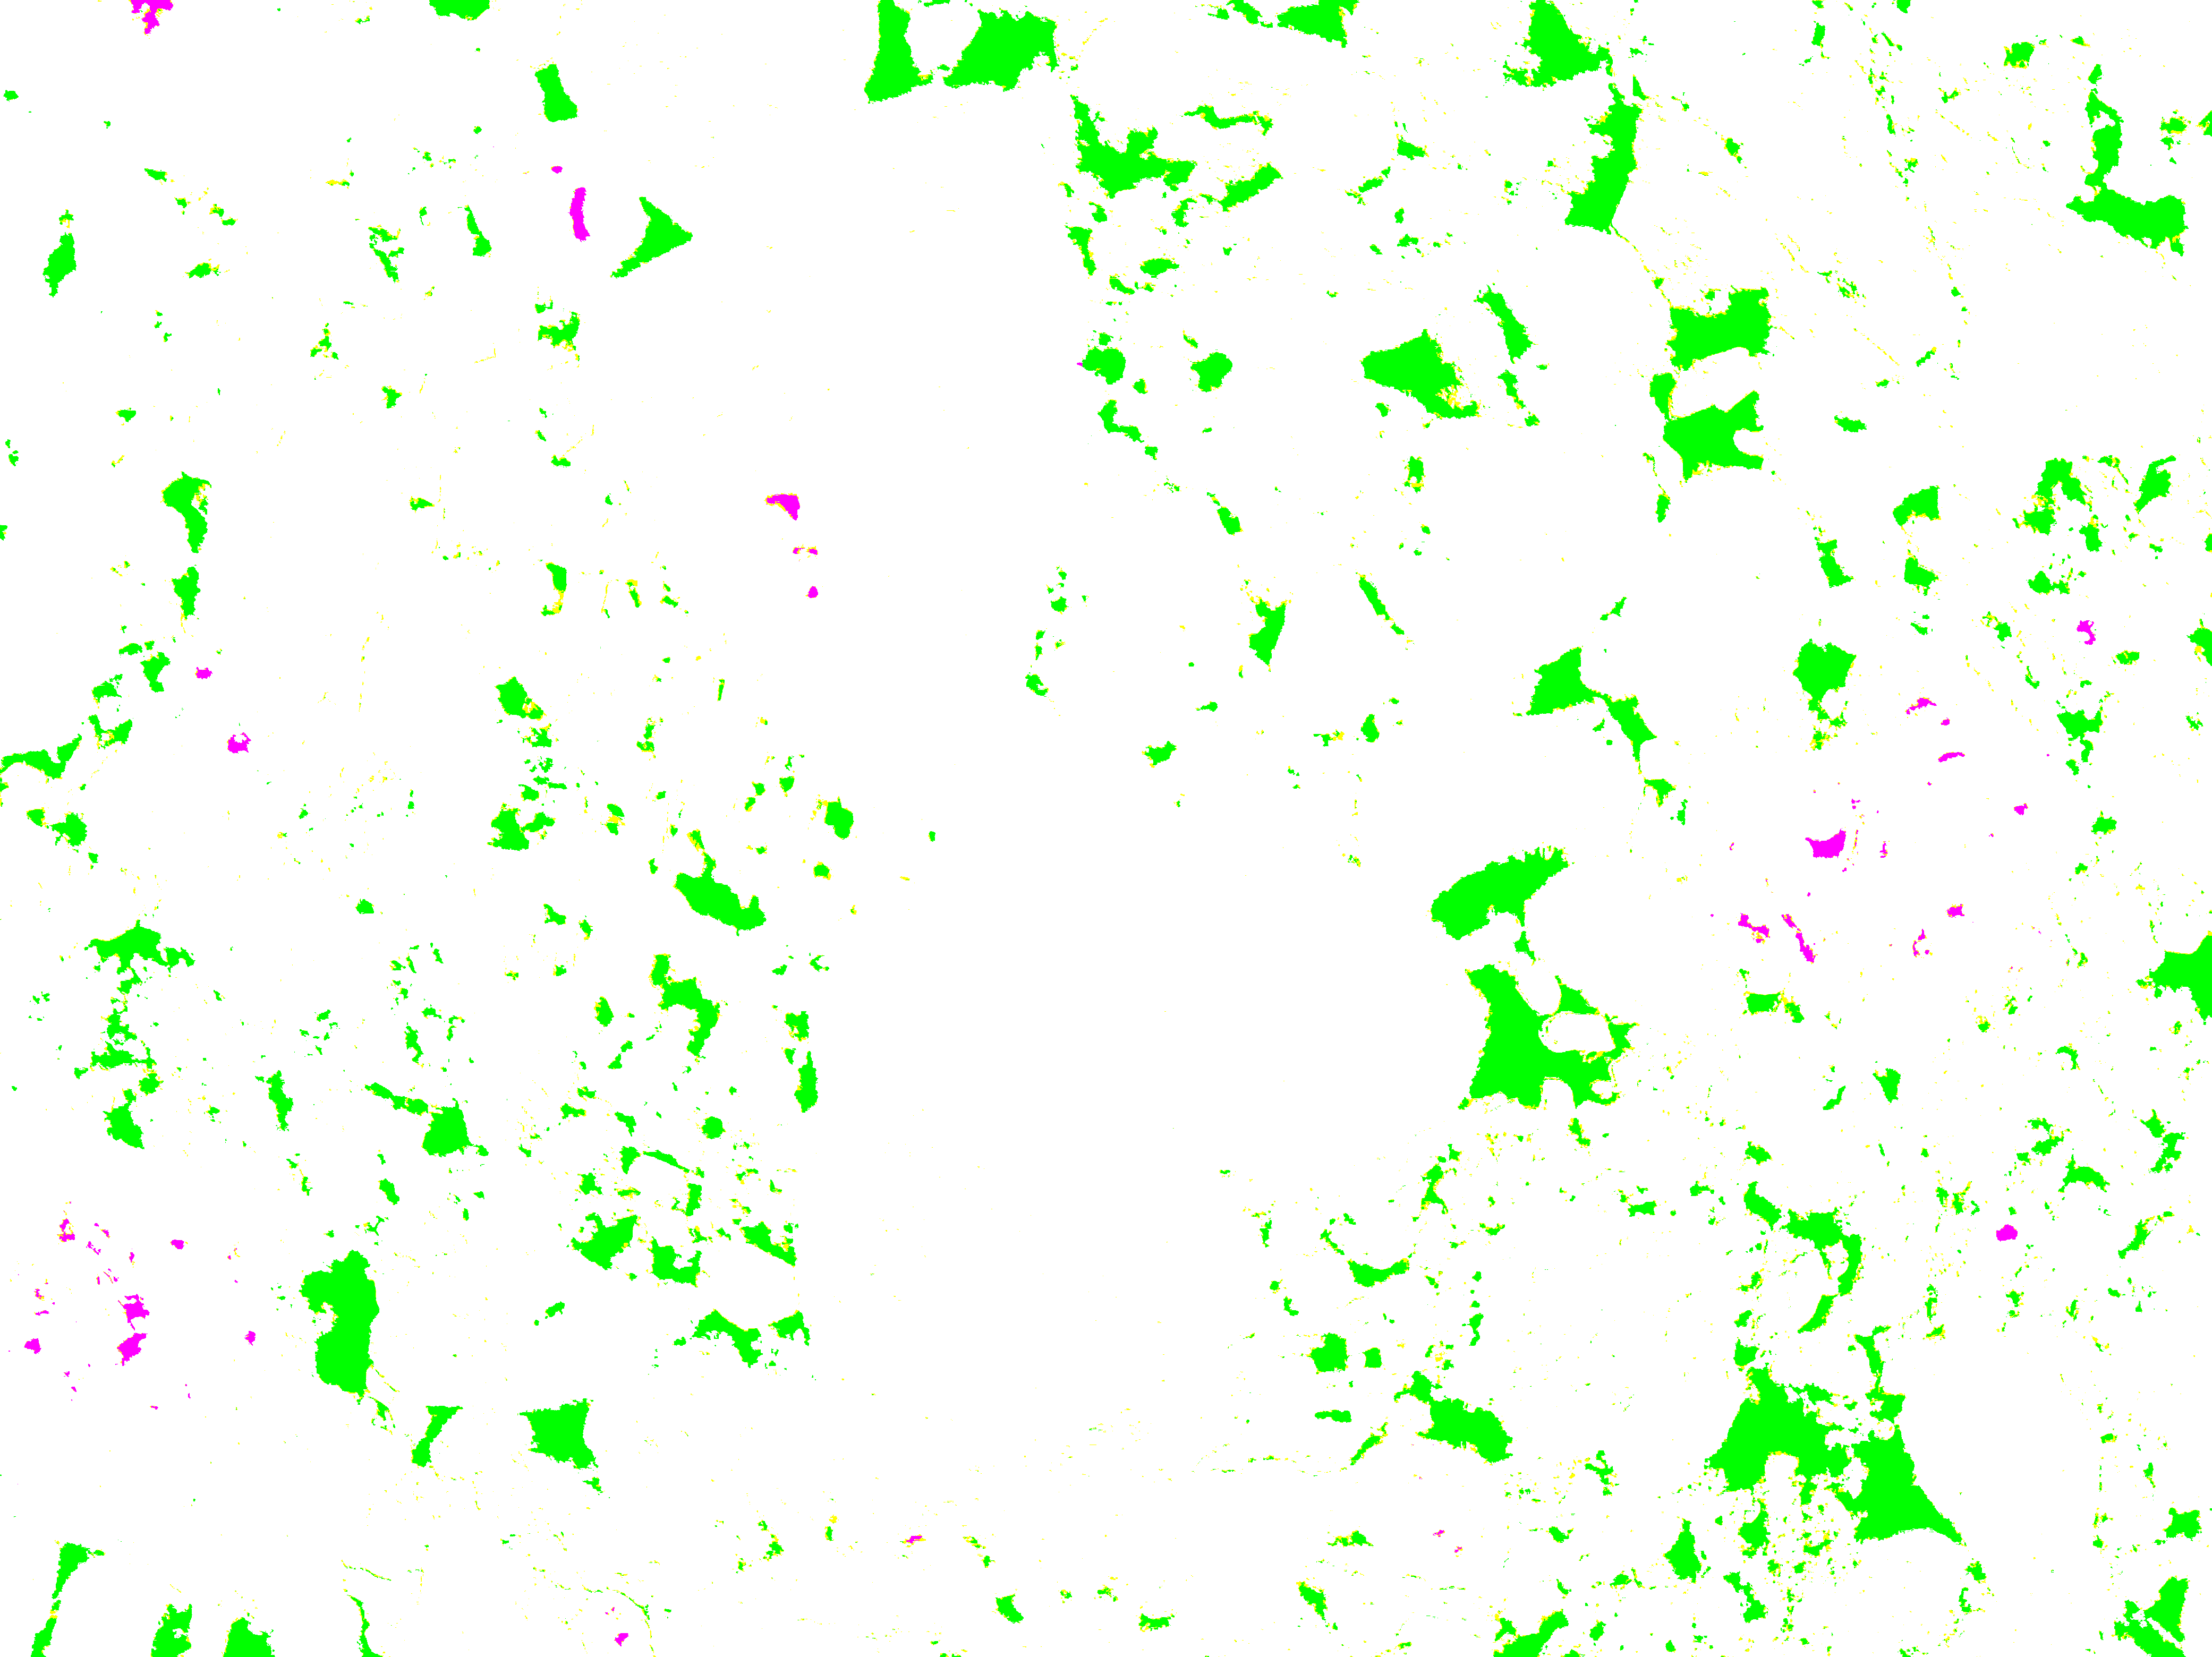

In [48]:
im = Image.open(r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\data\Имидж_АиВТ\Ю.Сюрхар\image_masks\351348_4.png")
im

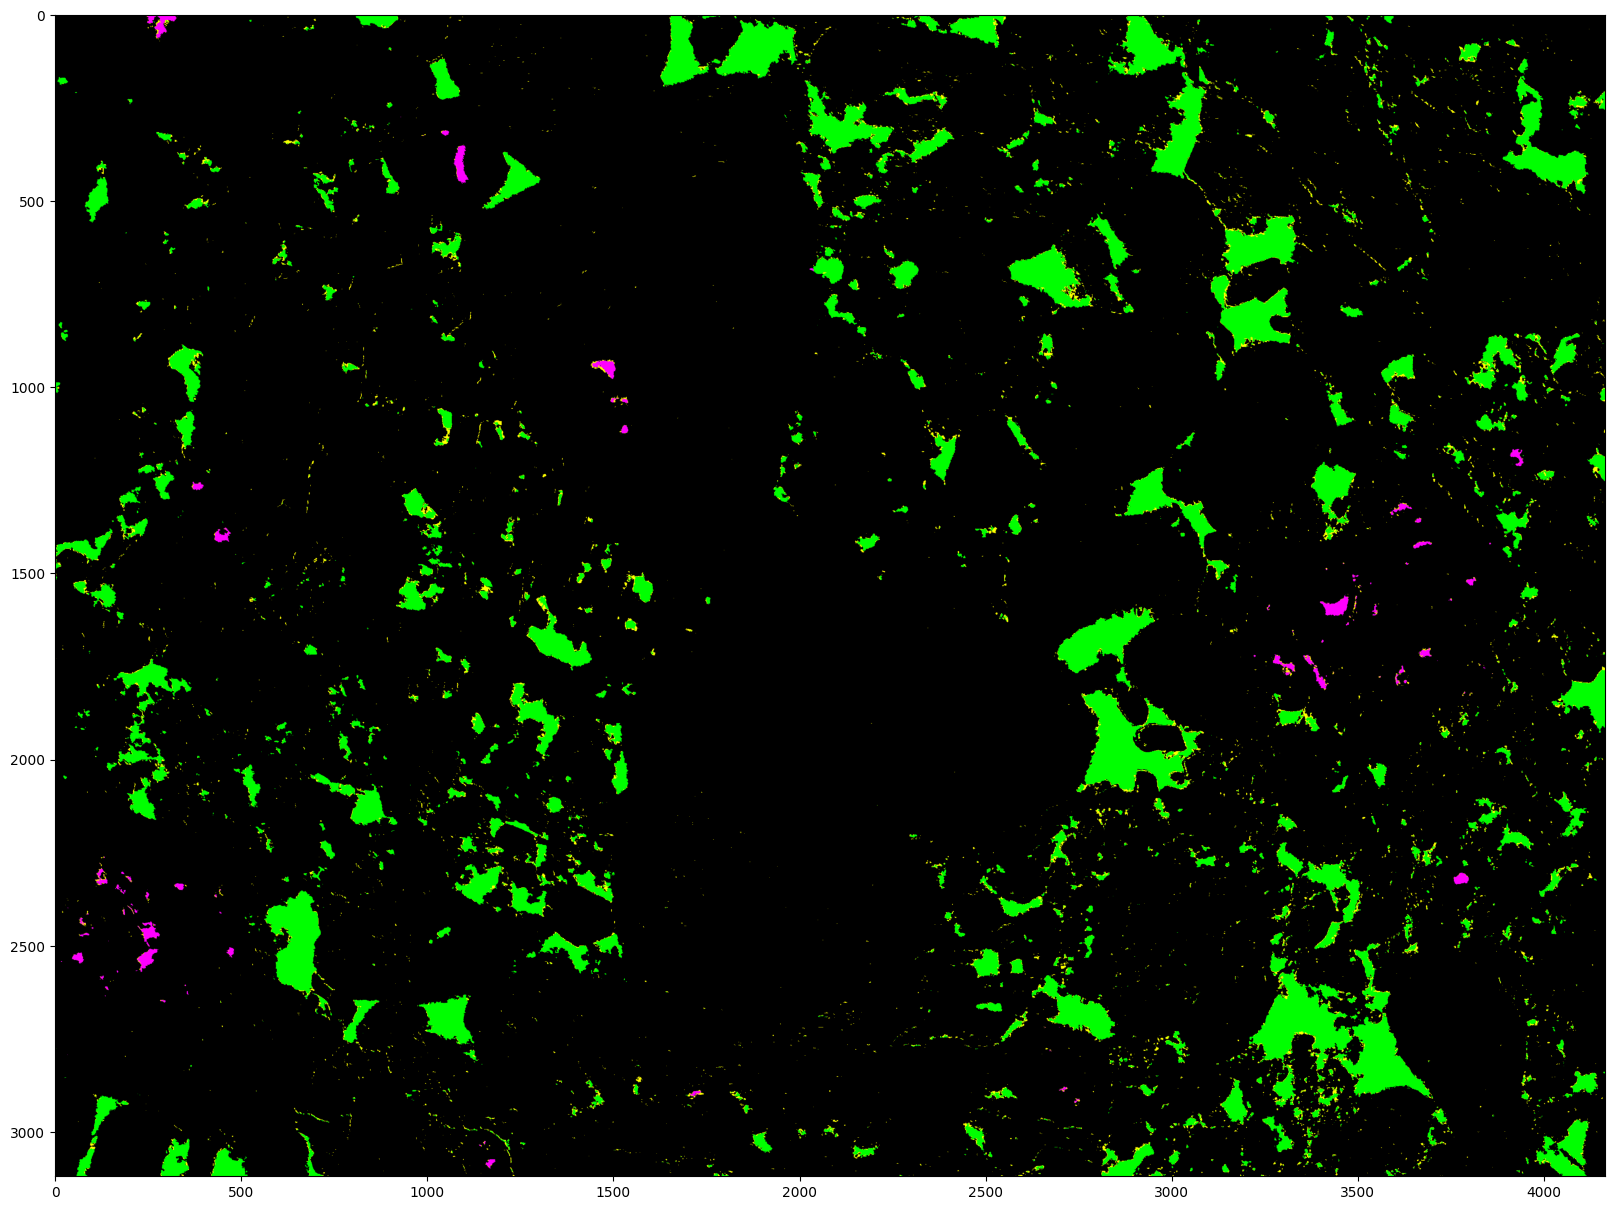

In [53]:
img = convert2rgb(im)
plt.figure(figsize=(20, 20))
plt.imshow(img);

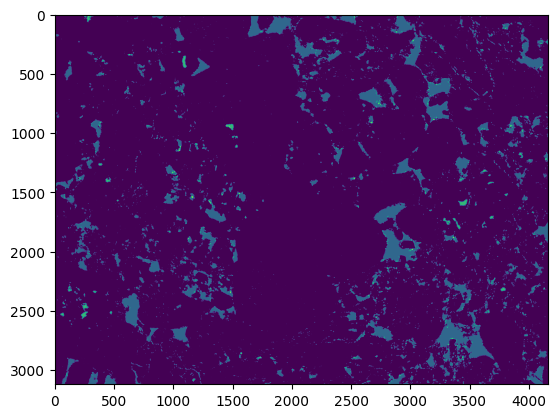

In [54]:
mask = convert2mask(img)
plt.imshow(mask * (255 // 5), cmap='viridis');

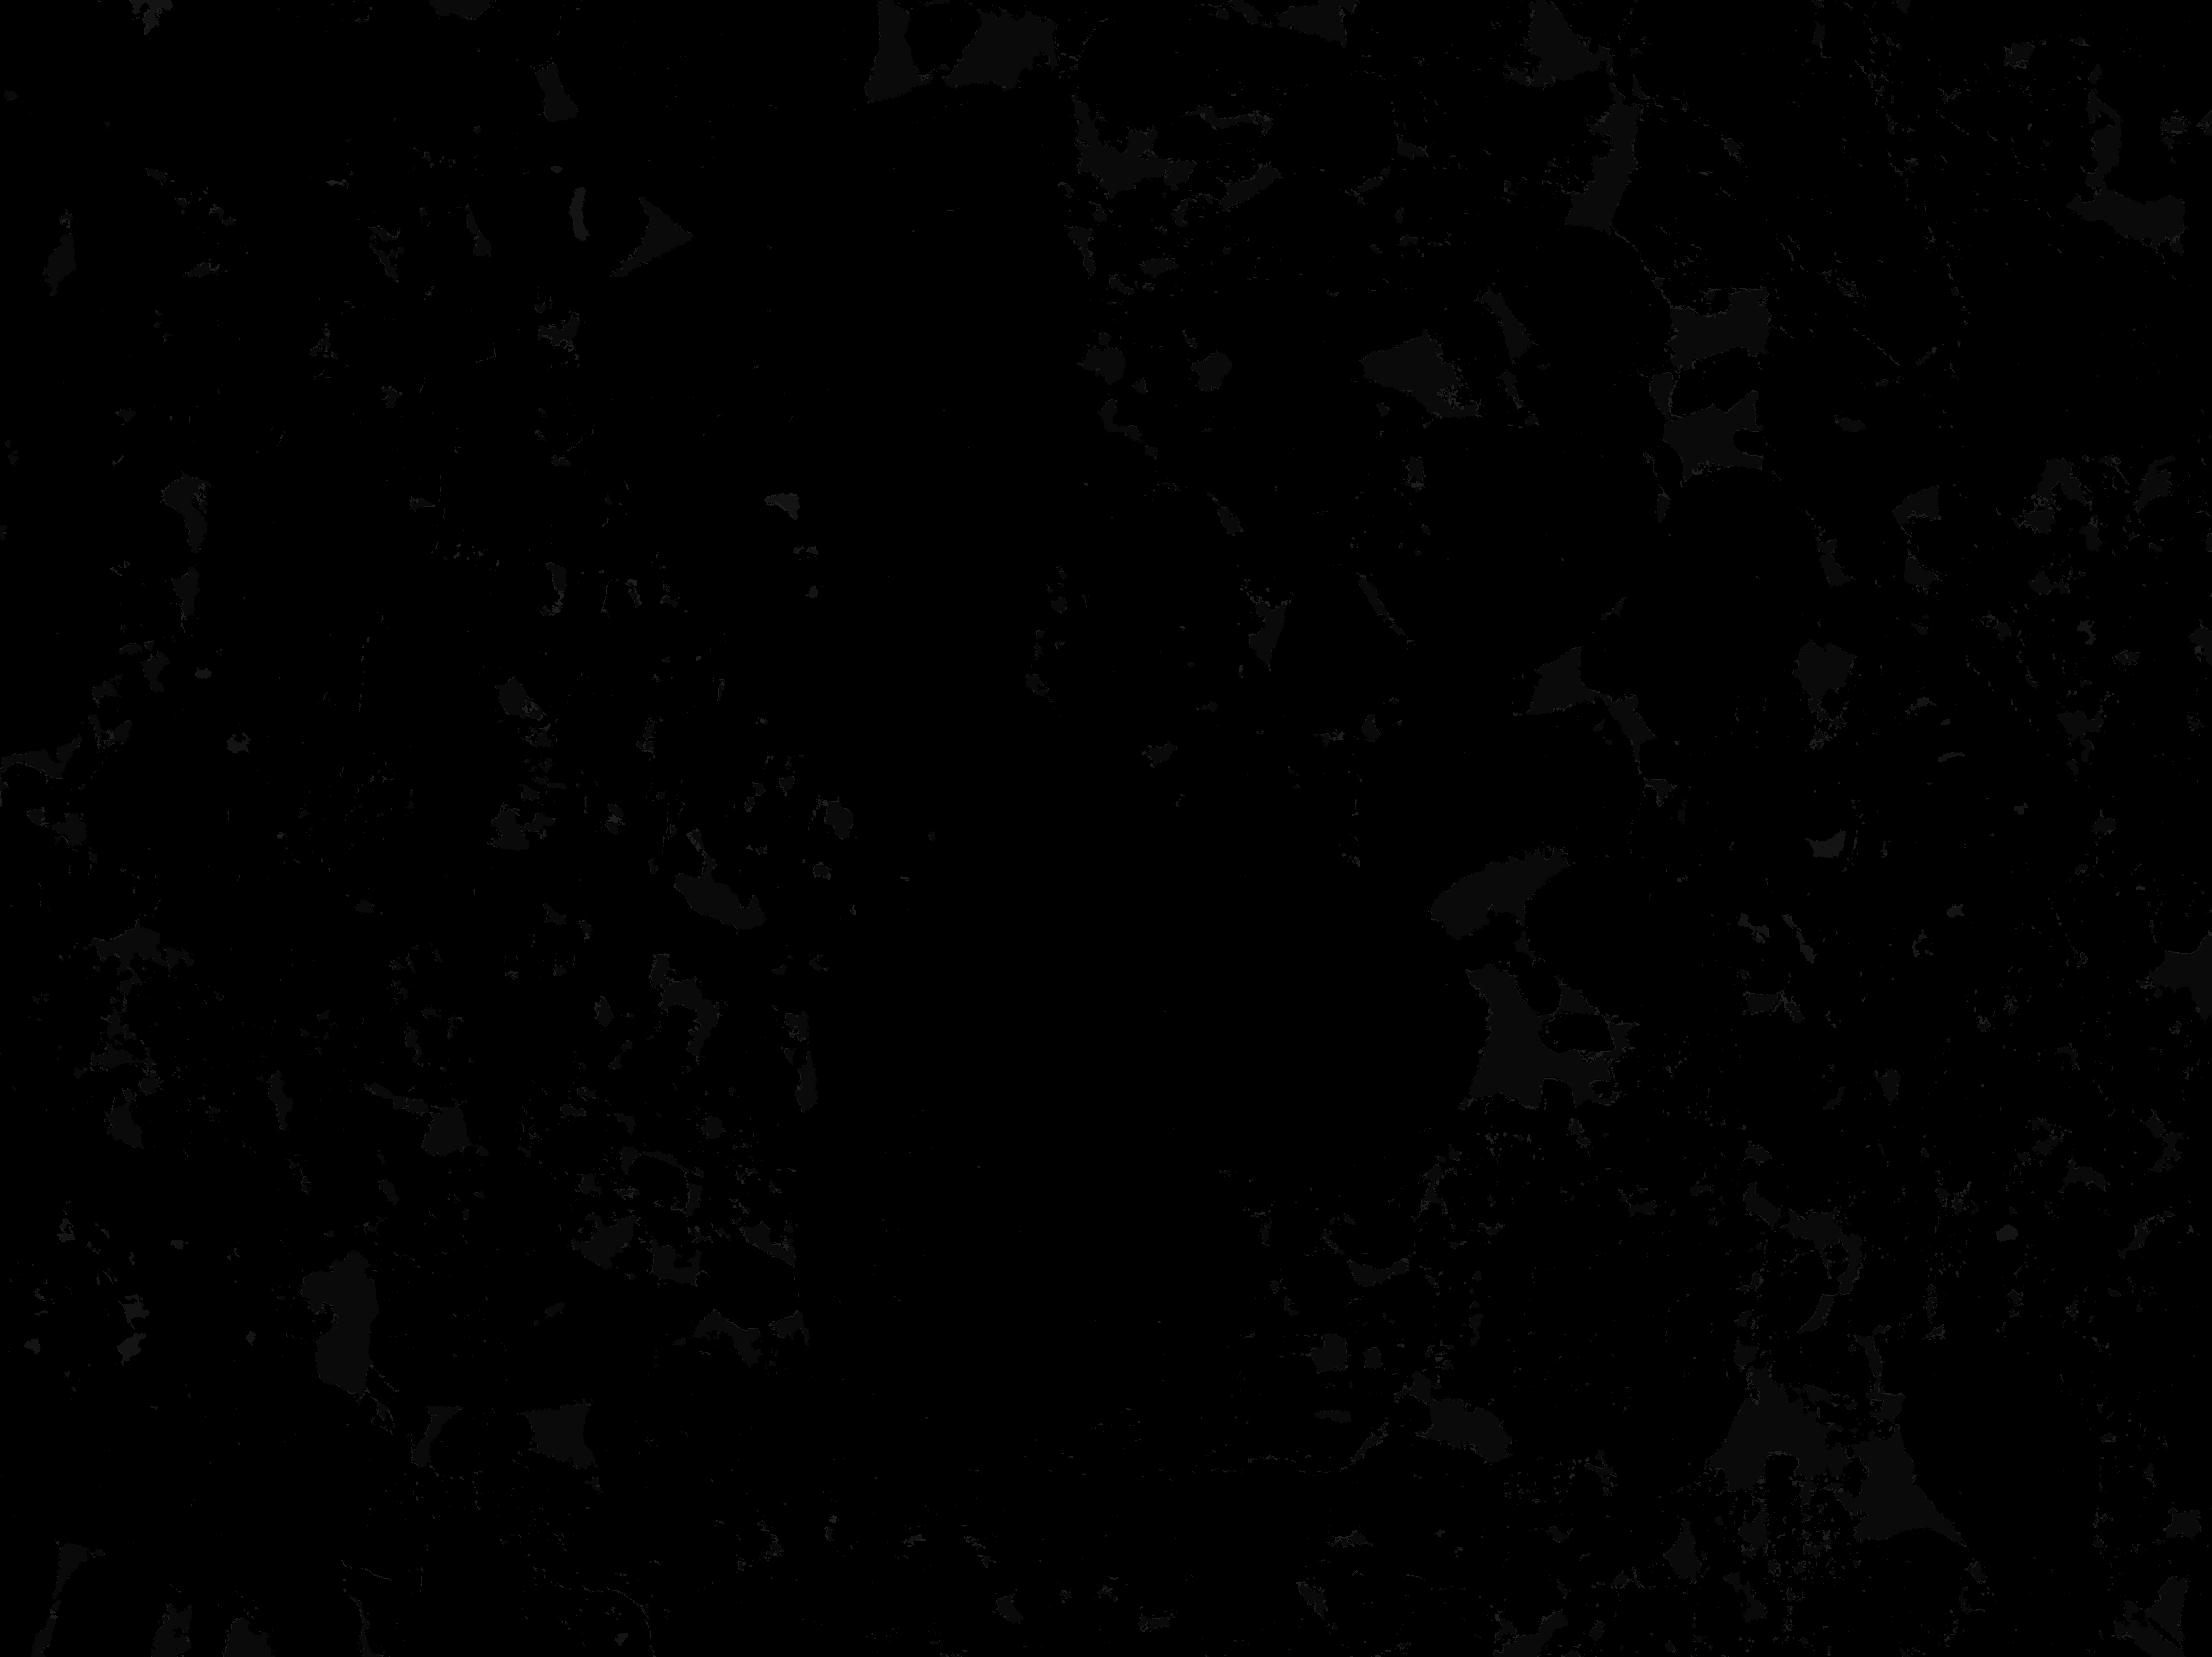

In [55]:
mask_im = Image.fromarray(mask * 10)
mask_im

In [56]:
mask_im.save('test.png')

In [57]:
mask_readed = Image.open("test.png")
mask_readed = np.array(mask_readed)
mask_readed.shape

(3120, 4164)

In [58]:
np.unique(mask_readed)

array([ 0, 10, 20, 30], dtype=uint8)

# Images processing

In [46]:
image_mask_and_mask_paths = {
    r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\data\Имидж_АиВТ\Ю.Сюрхар\image_masks":
    r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\data\Имидж_АиВТ\Ю.Сюрхар\masks",

    r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\data\Имидж_АиВТ\Сихор_32101\image_masks":
    r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\data\Имидж_АиВТ\Сихор_32101\masks"
}

In [47]:
# for image_mask_path, mask_path in image_mask_and_mask_paths.items():

#     assert os.path.exists(image_mask_path), f"Path {mask_path} does not exist"

#     paths = glob(image_mask_path + r'\*.png')
#     for path in tqdm.tqdm(paths, total=len(paths)):
#         image_name = os.path.basename(path)
#         try:
#             mask = convert2mask(
#                 convert2rgb(
#                     Image.open(path)
#                 )
#             )
#             mask = Image.fromarray(mask)
#         except Exception as e:
#             print(f'Error "{e}" with image {image_name}')
#             break
#         mask.save(mask_path + '\\' + image_name)

100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


# Masks Analisys

In [10]:
mask_paths = (
    glob(r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\data\Images\Sihor\masks\*.png")
    +
    glob(r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\data\Images\Surhar\masks\*.png")
)
len(mask_paths)

95

In [11]:
info_fields = ['name'] + [f'class{i}' for i in range(NUM_CLASSES)] + [f'class{i}Percent' for i in range(NUM_CLASSES)]
info_fields

['name',
 'class0',
 'class1',
 'class2',
 'class3',
 'class4',
 'class5',
 'class0Percent',
 'class1Percent',
 'class2Percent',
 'class3Percent',
 'class4Percent',
 'class5Percent']

In [12]:
info = defaultdict(list)

In [13]:
pd.DataFrame(info)

""


In [14]:
def get_mask_info(mask_path: str) -> dict:
    mask = read_img(mask_path, rgb=False)
    num_pixels = mask.shape[0] * mask.shape[1]
    info = {'name': os.path.basename(mask_path)}
    
    for class_index in range(NUM_CLASSES):
        class_percentage = (mask == class_index).sum() / num_pixels * 100
        info[f'class{class_index}'] = class_percentage != 0
        info[f'class{class_index}Percent'] = class_percentage
    return info
    

In [15]:
masks_info = list()
for mask_path in tqdm.tqdm(mask_paths, total=len(mask_paths)):
    masks_info.append(get_mask_info(mask_path))
masks_info

100%|██████████| 95/95 [00:07<00:00, 13.44it/s]


[{'name': '318261_1.png',
  'class0': True,
  'class0Percent': 96.82707702160151,
  'class1': True,
  'class1Percent': 2.9319225843001058,
  'class2': False,
  'class2Percent': 0.0,
  'class3': True,
  'class3Percent': 0.059337976304835095,
  'class4': True,
  'class4Percent': 0.1816624177935417,
  'class5': False,
  'class5Percent': 0.0},
 {'name': '318261_2.png',
  'class0': True,
  'class0Percent': 75.82299594817606,
  'class1': True,
  'class1Percent': 3.357756656567896,
  'class2': False,
  'class2Percent': 0.0,
  'class3': True,
  'class3Percent': 0.16472080593118058,
  'class4': True,
  'class4Percent': 0.030650385477474812,
  'class5': True,
  'class5Percent': 20.623876203847384},
 {'name': '318261_3.png',
  'class0': True,
  'class0Percent': 98.46772703761177,
  'class1': True,
  'class1Percent': 1.4925860242863125,
  'class2': True,
  'class2Percent': 0.005218724599128057,
  'class3': True,
  'class3Percent': 0.034468213502795636,
  'class4': False,
  'class4Percent': 0.0,
  

In [20]:
classes_i = [f'class{i}' for i in range(NUM_CLASSES)]

masks_info_df = pd.DataFrame(masks_info)[info_fields]
masks_info_df[classes_i] = masks_info_df[classes_i].astype(int)
masks_info_df

,name,class0,class1,class2,class3,class4,class5,class0Percent,class1Percent,class2Percent,class3Percent,class4Percent,class5Percent
0,318261_1.png,1,1,0,1,1,0,96.827077,2.931923,0.000000,0.059338,0.181662,0.000000
1,318261_2.png,1,1,0,1,1,1,75.822996,3.357757,0.000000,0.164721,0.030650,20.623876
2,318261_3.png,1,1,1,1,0,0,98.467727,1.492586,0.005219,0.034468,0.000000,0.000000
3,318261_4.png,1,1,0,1,0,1,92.413876,3.397590,0.000000,0.050802,0.000000,4.137733
4,318349_1.png,1,1,1,1,0,0,98.207861,1.546213,0.161195,0.084731,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,352037_4.png,1,1,1,1,1,0,97.194304,1.748150,0.368012,0.018974,0.670560,0.000000
91,352872_1.png,1,1,1,1,1,0,99.399100,0.283320,0.104036,0.152998,0.060546,0.000000
92,352872_2.png,1,1,1,1,0,0,99.148778,0.436603,0.258150,0.156469,0.000000,0.000000
93,352872_3.png,1,1,0,0,0,0,99.740072,0.259928,0.000000,0.000000,0.000000,0.000000


In [23]:
masks_info_df[info_fields[1:]].mean()

class0            1.000000
class1            1.000000
class2            0.884211
class3            0.947368
class4            0.231579
class5            0.210526
class0Percent    95.667382
class1Percent     2.761656
class2Percent     0.277113
class3Percent     0.492122
class4Percent     0.079803
class5Percent     0.721924
dtype: float64

In [25]:
masks_info_df[info_fields[1:]].std()

class0           0.000000
class1           0.000000
class2           0.321670
class3           0.224481
class4           0.424079
class5           0.409845
class0Percent    3.894393
class1Percent    2.371157
class2Percent    0.245481
class3Percent    0.547761
class4Percent    0.234776
class5Percent    2.486816
dtype: float64

In [26]:
masks_info_df.loc[(masks_info_df['class4'] != 0) & (masks_info_df['class5'] != 0)]

,name,class0,class1,class2,class3,class4,class5,class0Percent,class1Percent,class2Percent,class3Percent,class4Percent,class5Percent
1,318261_2.png,1,1,0,1,1,1,75.822996,3.357757,0.000000,0.164721,0.030650,20.623876
57,349391_2.png,1,1,0,1,1,1,92.856736,0.782054,0.000000,1.018460,1.411742,3.931008
61,350783_2.png,1,1,1,1,1,1,82.075852,4.803967,0.432731,3.092318,0.051279,9.543854


In [21]:
masks_info_df.to_excel(r"C:\Users\Viktor\Documents\IT\ReservoirRockAnalysis\src\metadata\masks_info.xlsx")